In [1]:
import flwr as fl 
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tasks as ts
import warnings
import argparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt




In [2]:
# ts.__dict__

In [2]:
data_1 = pd.read_csv('../IID_df_1.csv')
data_2 = pd.read_csv('../IID_df_2.csv')

In [3]:
scaler = MinMaxScaler()
smote = SMOTE(random_state=422)


In [4]:
test = pd.read_csv('../test_glob.csv')

In [5]:

X_train_2, y_train_2 = data_2.drop(columns=["Fraud"]), data_2["Fraud"]





X_train_scale_2 = scaler.fit_transform(X_train_2)
X_train_2, y_train_2 = smote.fit_resample(X_train_scale_2, y_train_2)


X_test, y_test = test.drop(columns='Fraud'), test.Fraud 
X_test_scale = scaler.transform(X_test)

model = LogisticRegression(
max_iter=10
)

In [6]:


def plot_metrics(losses, ROC_AUC, ACCURACY, F1):
   
    rounds = list(range(1, len(losses) + 1))
    
    plt.figure(figsize=(12, 8))
  
    plt.subplot(2, 2, 1)
    plt.plot(rounds, losses, color='blue')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2, 2, 2)
    plt.plot(rounds, ROC_AUC, color='green')
    plt.title("ROC AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")

    plt.subplot(2, 2, 3)
    plt.plot(rounds, ACCURACY, color='orange')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(2, 2, 4)
    plt.plot(rounds, F1, color='red')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    plt.show()





In [7]:
X_train, X_test, y_train, y_test = X_train_2, X_test_scale, y_train_2, y_test

In [ ]:
# data = pd.read_csv('../Non_IID_df_1.csv')

In [ ]:
# X_train, y_train = data.drop(columns='Fraud'), data.Fraud

# X_train_scale = scaler.fit_transform(X_train)
# X_train_, y_train_ = smote.fit_resample(X_train_scale, y_train)

In [39]:
class CustomClientDP(fl.client.NumPyClient):
  
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []

    def get_parameters(self, config):
         
        return ts.get_model_parameters(model)
    
    def fit(self, parameters, config):
        ts.set_model_parameters(model, parameters)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
    
        
        return ts.get_model_parameters(model), len(X_train), {}

    def evaluate(self, parameters, config):
        
        ts.set_model_parameters(model, parameters)
        
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
       
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)

        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')

        
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


if __name__ == "__main__":
    N_CLIENTS = 2

    model = LogisticRegression(
        max_iter=1,
        warm_start=True
    )

    ts.set_initial_parameters(model)
    
    
    client_dp = CustomClientDP(model, X_train, X_test, y_train, y_test)

    
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_dp
    )


INFO :      
INFO :      Received: get_parameters message b4ebc6bf-5f68-401b-b2fb-c88c99abc4d2
INFO :      Sent reply


INFO :      
INFO :      Received: train message 4dd311d3-b129-4bce-9f23-0cff2ccd91fc
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6df628b4-908b-46be-bb1a-2e6a74167792
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1b30d20e-e6a5-4014-8b2c-1a3e3ea2e640
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message bc91456c-c26d-4464-90b4-312c2ad3bca4
INFO :      Sent reply
INFO :      
INFO :      Received: train message d122553a-586b-4a68-8c22-5e5cca5a2e41
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d81b6506-e760-4355-b28d-c1beb00a006c
INFO :      Sent reply
INFO :      
INFO :      Received: train message 40680504-d059-4fa4-81dd-850c2b080c64
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 73ae0451-2f86-4da0-9e76-743e671d2bde
INFO :      Sent reply


accuracy: 0.7801556420233463
ROC_AUC: 0.6555325987144168
f1_score: 0.13959390862944163
accuracy: 0.8715953307392996
ROC_AUC: 0.6936333027242119
f1_score: 0.16101694915254236
accuracy: 0.8949416342412452
ROC_AUC: 0.7109523262932353
f1_score: 0.15625
accuracy: 0.6747730220492867
ROC_AUC: 0.7119318181818183
f1_score: 0.19308125502815768


INFO :      
INFO :      Received: train message 47774ac7-fcef-4e0e-9bc8-d9c4e852cbe1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d3affeea-5fbf-4dad-9a15-964019a67d63
INFO :      Sent reply
INFO :      
INFO :      Received: train message 99245aa5-8a01-4bb1-a7d1-3dc218cdc204
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 441388ee-50e1-4f36-9adb-347c34265b93
INFO :      Sent reply
INFO :      
INFO :      Received: train message 9c2c39e5-b654-4c00-ba11-1f5d68064d8a
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 612da5c4-1c0f-4909-9cb9-4065acafcd3c
INFO :      Sent reply
INFO :      
INFO :      Received: train message b1307782-87fe-4985-bc51-2a4b733c3505
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 2ab2aeb0-b353-46e9-8377-7179df36236f


accuracy: 0.9121271076523995
ROC_AUC: 0.7336910774410774
f1_score: 0.11726384364820847
accuracy: 0.8336575875486382
ROC_AUC: 0.7224039638812365
f1_score: 0.1792
accuracy: 0.7166018158236057
ROC_AUC: 0.7192569635751453
f1_score: 0.1922365988909427


INFO :      Sent reply
INFO :      
INFO :      Received: train message fe08aa58-06a4-4ed8-9ac7-cd2f3246e4f8
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 552582df-a5bb-461c-9bd1-a238df488563
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3bfb7d19-d8f7-4bf5-b5c4-ab81e1267621
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8a215b70-38ff-4c02-a138-75aed47c1f81
INFO :      Sent reply
INFO :      
INFO :      Received: train message bd4e3ba5-0f34-4fc0-aa8e-510efeac73fe
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 7cacd0d8-70a4-4326-a6f5-7cb74f5bddd2
INFO :      Sent reply
INFO :      
INFO :      Received: train message cd0b2238-855c-4fee-af59-f1a543b9eba7
INFO :      Sent reply
INFO :      


accuracy: 0.7162775616083009
ROC_AUC: 0.7282082185491277
f1_score: 0.19798350137488543
accuracy: 0.7123865110246433
ROC_AUC: 0.7266127180899908
f1_score: 0.20162016201620162
accuracy: 0.708171206225681
ROC_AUC: 0.7256772268135905
f1_score: 0.19786096256684493
accuracy: 0.6653696498054474
ROC_AUC: 0.728030303030303
f1_score: 0.19248826291079812


INFO :      Received: evaluate message 3f27b399-06aa-44e8-bd25-ca1fa09d1edc
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3b5675c5-518f-4380-953e-51f00439ac11
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 3e41eb60-3a95-4a34-baad-3d47b6512f2e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 8381e065-a025-4cca-aa7b-b8844e64a367
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 8a78f83b-8c08-4f54-b5d6-961adff0e3cd
INFO :      Sent reply
INFO :      
INFO :      Received: train message 214de9d9-ef49-4eeb-b8a5-d938c91a7baa
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 1407e7e3-a469-4ed1-a9e9-4498869c2fb1
INFO :      Sent reply
INFO :      
INFO :      Received: train message 05e338f8-e8e9-4e5b-b51a-29389cad7697
INFO :      Sent reply
INFO :      


accuracy: 0.6796368352788587
ROC_AUC: 0.7293369299051118
f1_score: 0.2032258064516129
accuracy: 0.7091439688715954
ROC_AUC: 0.7338249923477196
f1_score: 0.20266666666666666
accuracy: 0.7026588845654993
ROC_AUC: 0.7355601469237832
f1_score: 0.20330147697654213
accuracy: 0.7331387808041504
ROC_AUC: 0.7382193143556779
f1_score: 0.19863680623174293


INFO :      Received: evaluate message 2f45741f-af79-4866-b3e1-11dc43fbdcf1
INFO :      Sent reply
INFO :      
INFO :      Received: train message 90972c14-ce78-4635-9c20-569b5f6b0559
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message e1324944-2734-4112-91ba-940ba3bdcfa4
INFO :      Sent reply
INFO :      
INFO :      Received: train message 92c6a26b-4c62-4ceb-93a0-2476cc5f5ac9
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 9d9bf142-7736-4e3d-b637-0a9c0aeb192b
INFO :      Sent reply
INFO :      
INFO :      Received: train message 958770cb-a955-4b02-97e8-77d9a90867f9
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 11ebfefb-59cd-475e-a5eb-eb958fb88174
INFO :      Sent reply


accuracy: 0.6883916990920882
ROC_AUC: 0.7374579124579124
f1_score: 0.20512820512820512
accuracy: 0.667639429312581
ROC_AUC: 0.7382977502295683
f1_score: 0.20233463035019456
accuracy: 0.6864461738002594
ROC_AUC: 0.7393595041322314
f1_score: 0.20802620802620803
accuracy: 0.6627756160830091
ROC_AUC: 0.7402662993572084
f1_score: 0.20245398773006135


INFO :      
INFO :      Received: train message 9621eb8c-b218-4a11-85c4-ac71d6f687b8
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 147a649e-e84e-4008-9322-f716175b8d3e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 83c60571-4865-48cb-8789-c7d9f5bf895f
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message be36a34b-12db-4df8-9e74-1d51cf1bf104
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4a1e09ef-0886-4d85-8bae-461569a04c3d
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 37b82c53-d30f-4545-93a9-836433db832e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 8b7e3fe0-68fe-46e5-b898-2c812053bba3
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 11ffb360-0cca-4ef2-b2bd-b1f6550fec70
INFO :      Sent reply
INFO :      
INFO :      Received: train message e72c907e-6eb5-4ca9-a945-dfe755feffd5
INFO :      Sent reply


accuracy: 0.6845006485084306
ROC_AUC: 0.7408937863483318
f1_score: 0.2057142857142857
accuracy: 0.6825551232166018
ROC_AUC: 0.7416035353535353
f1_score: 0.20728744939271254
accuracy: 0.6883916990920882
ROC_AUC: 0.7428336394245485
f1_score: 0.20905349794238684
accuracy: 0.687094682230869
ROC_AUC: 0.7435204315886135
f1_score: 0.20706655710764174


INFO :      
INFO :      Received: evaluate message c9854aad-b42b-4bf9-a870-43d5593fb6be
INFO :      Sent reply
INFO :      
INFO :      Received: train message 05353315-d45b-4c09-b325-2607b7803ffd
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 20ed7a8b-1cb8-48d2-8f26-edad9793c406
INFO :      Sent reply
INFO :      
INFO :      Received: train message 790ccd55-34d9-465f-9fe0-f1661b9ab610
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 304a38ae-6635-4337-acd8-4fc4a3ee269d
INFO :      Sent reply
INFO :      
INFO :      Received: train message ffb26c12-4af7-4657-8388-d5629c989114
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 1b0b9de0-16ff-40a7-97a6-a81ffb9bad31
INFO :      Sent reply
INFO :      
INFO :      Received: train message 615ecaab-09d0-4d3c-bcda-b5b7bf2f7e0c
INFO :      Sent reply


accuracy: 0.6913099870298314
ROC_AUC: 0.7439508723599633
f1_score: 0.2079866888519135
accuracy: 0.6793125810635539
ROC_AUC: 0.7438207835935109
f1_score: 0.20816653322658127
accuracy: 0.6679636835278858
ROC_AUC: 0.7441192225283134
f1_score: 0.2062015503875969
accuracy: 0.6647211413748378
ROC_AUC: 0.7445496632996632
f1_score: 0.20461538461538462


INFO :      
INFO :      Received: evaluate message 7b2e95b8-ec0e-48e5-a7d7-c0069fe51323
INFO :      Sent reply
INFO :      
INFO :      Received: train message 809a179d-76b7-44c1-a695-72d59dc6c7b1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 175600a5-a036-4ec8-a0ce-30e625b65f80
INFO :      Sent reply
INFO :      
INFO :      Received: train message 0811d66b-b8c7-4aaa-9464-6d103f762abc
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 3c5c199d-ebd2-4e2f-acc7-fe51e1b81442
INFO :      Sent reply
INFO :      
INFO :      Received: train message 60886845-92cc-4161-8c75-96a29b94a245


accuracy: 0.6721789883268483
ROC_AUC: 0.7449992347719621
f1_score: 0.20581304006284368
accuracy: 0.6738002594033723
ROC_AUC: 0.7448863636363636
f1_score: 0.20662460567823343
accuracy: 0.6757457846952011
ROC_AUC: 0.7451580195898379
f1_score: 0.20508744038155802


INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 706293ea-22bb-4a83-890a-d0dbf92d5080
INFO :      Sent reply
INFO :      
INFO :      Received: train message 860f98fc-3712-45d5-bcb4-9ddf63fedbeb
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 92b22b7a-d63c-4069-9b2f-ef5cd2ad90e7
INFO :      Sent reply
INFO :      
INFO :      Received: train message 41cb9a59-ecfd-4516-9eaf-8d81aa439863
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 9f3cea66-df0b-4dce-8c44-09f57757d398
INFO :      Sent reply
INFO :      
INFO :      Received: train message 63551257-be65-4f3a-b00c-179334f3abab
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 871164ca-8266-4fa5-9445-17b9e40e54ba
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3740ef99-c69d-43ae-84ad-c0a0224ba9c0
INFO :      Sent reply
INFO :      


accuracy: 0.6757457846952011
ROC_AUC: 0.7454335016835016
f1_score: 0.20508744038155802
accuracy: 0.6744487678339819
ROC_AUC: 0.745548285889195
f1_score: 0.20443740095087162
accuracy: 0.6750972762645915
ROC_AUC: 0.7457931588613407
f1_score: 0.20476190476190476
accuracy: 0.6734760051880675
ROC_AUC: 0.7459060299969391
f1_score: 0.20395256916996046


INFO :      Received: evaluate message 7d1c2cbd-f650-4e62-b3ab-71a460c62d2b
INFO :      Sent reply
INFO :      
INFO :      Received: train message 320b88bd-c58c-4a56-b176-8533040c69eb
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 1424f0d5-4a62-4b22-be03-02f44348c066
INFO :      Sent reply
INFO :      
INFO :      Received: train message 56ff11e6-21a3-4167-aee8-f98c7b6ac6e6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message d8ed6991-3976-4de3-9983-78104260a4fb
INFO :      Sent reply
INFO :      
INFO :      Received: train message 3f04b217-d7df-4b01-b856-601589ef944a
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message eee63b44-84da-4c3d-8e72-64d01c0617e9
INFO :      Sent reply
INFO :      
INFO :      Received: train message 67edbc52-8028-4dad-9ae5-59950df5188a
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6c241b62-3f5a-4f70-b3a7-7eeac09e81eb


accuracy: 0.6734760051880675
ROC_AUC: 0.7461279461279461
f1_score: 0.20395256916996046
accuracy: 0.6741245136186771
ROC_AUC: 0.7461834251606978
f1_score: 0.2042755344418052
accuracy: 0.6744487678339819
ROC_AUC: 0.7461853382307928
f1_score: 0.20443740095087162
accuracy: 0.6741245136186771
ROC_AUC: 0.7462102081420263
f1_score: 0.2042755344418052


INFO :      Sent reply
INFO :      
INFO :      Received: train message 8943bc81-c854-4ce6-a077-ca3543b1fd57
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message bdea129d-5fb5-4afc-b46a-f2697e018d20
INFO :      Sent reply
INFO :      
INFO :      Received: train message 1583e89f-fc24-410c-8cd9-4bd8908ea5e1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 5cd5a538-9433-4a7e-b809-47c0fa0ff77f
INFO :      Sent reply
INFO :      
INFO :      Received: train message dd808448-f83f-4f8e-b2f9-a367481398f1
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message ddfb48e3-f625-43dd-9afc-9762d7f6ebc5
INFO :      Sent reply
INFO :      
INFO :      Received: train message dc83cc6b-07b3-4af9-a92f-2653338f4e19
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message a10357a5-4573-4dd6-bbb0-e93acddbc14e
INFO :      Sent reply
INFO :      
INFO :      Received: train message c27f0e65-dfa5-45e3-9ee6-7098636bf40e
INFO : 

accuracy: 0.6741245136186771
ROC_AUC: 0.7462771655953473
f1_score: 0.2042755344418052
accuracy: 0.6760700389105059
ROC_AUC: 0.7462790786654424
f1_score: 0.2052505966587112
accuracy: 0.6734760051880675
ROC_AUC: 0.7462389041934495
f1_score: 0.20395256916996046
accuracy: 0.6734760051880675
ROC_AUC: 0.7464225589225588
f1_score: 0.20395256916996046
accuracy: 0.6744487678339819
ROC_AUC: 0.7465201254973981
f1_score: 0.20443740095087162


INFO :      
INFO :      Received: evaluate message b8218b40-930a-4287-b980-92d9fc8b1d06
INFO :      Sent reply
INFO :      
INFO :      Received: train message dd46c374-d18f-4925-8f4c-fb364df79f60
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 98946902-62ba-4c86-b326-11c23c8519cc
INFO :      Sent reply
INFO :      
INFO :      Received: train message c86eede4-d9ee-4ede-82fb-40252abb666e
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 59cc51e5-f198-45cb-9650-201800f51e39
INFO :      Sent reply
INFO :      
INFO :      Received: train message 14b37342-e26d-4b1a-ac59-617ffdc27902
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 685d528f-d802-42e8-8073-a08afb3f150e
INFO :      Sent reply
INFO :      
INFO :      Received: train message 4816c153-545e-4338-bdd9-0c7eaa92bf6b
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message 6ad8055b-86f5-4a82-bed0-baa5463fb2c0
INFO :      Sent reply
INFO

accuracy: 0.6757457846952011
ROC_AUC: 0.7466004744413834
f1_score: 0.20508744038155802
accuracy: 0.6767185473411155
ROC_AUC: 0.7466884756657485
f1_score: 0.20557768924302788
accuracy: 0.6754215304798963
ROC_AUC: 0.7466463881236609
f1_score: 0.20492454328832407
accuracy: 0.6757457846952011
ROC_AUC: 0.7466827364554638
f1_score: 0.20508744038155802
accuracy: 0.6763942931258107
ROC_AUC: 0.7466750841750842
f1_score: 0.2054140127388535


INFO :      Received: evaluate message 871569d5-3659-4575-a0f1-0b48103f9395
INFO :      Sent reply
INFO :      
INFO :      Received: train message deb97981-47d5-4402-a025-225b968bd2c6
INFO :      Sent reply
INFO :      
INFO :      Received: evaluate message f5426f3e-00f2-4f65-96ad-fc23095503bb
INFO :      Sent reply
INFO :      
INFO :      Received: reconnect message 6725dbb3-878e-435a-b5a1-8222b7b8cb85
INFO :      Disconnect and shut down


accuracy: 0.6760700389105059
ROC_AUC: 0.7467401285583103
f1_score: 0.2052505966587112
accuracy: 0.6760700389105059
ROC_AUC: 0.7467649984695439
f1_score: 0.2052505966587112


---

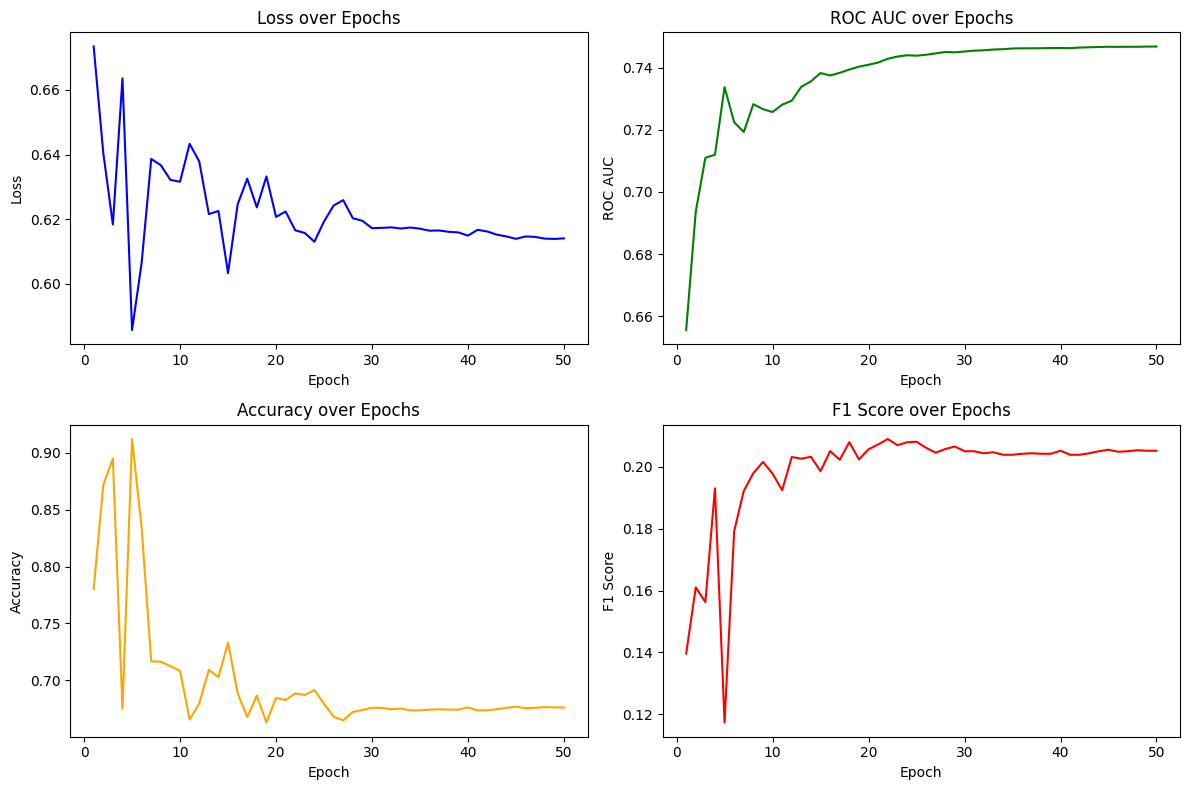

In [40]:
L, ROC_AUC, ACCURACY, F1 = client_dp.losses, client_dp.ROC_AUCs, client_dp.ACCURACYs, client_dp.F1s

plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [14]:
L_dp_fixed, ROC_AUC_dp_fixed, ACCURACY_dp_fixed, F1_dp_fixed = L, ROC_AUC, ACCURACY, F1 

In [41]:
L_dp_adap, ROC_AUC_dp_adap, ACCURACY_dp_adap, F1_dp_adap = L, ROC_AUC, ACCURACY, F1 

In [36]:
L_fedavg, ROC_AUC_fedavg, ACCURACY_fedavg, F1_fedavg = L, ROC_AUC, ACCURACY, F1



In [42]:
L_dp_adap == L_fedavg

False

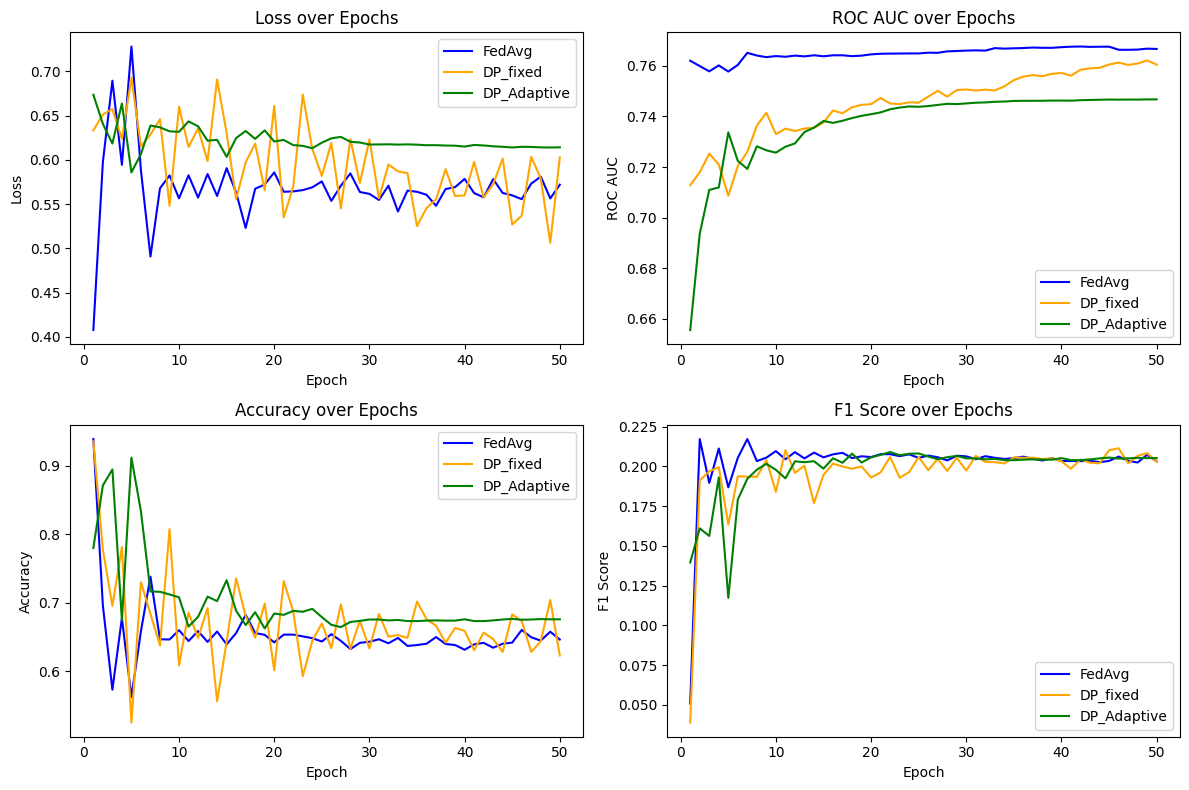

In [ ]:
def plot_metrics_comparison_simple(L_1, ROC_AUC_1, ACCURACY_1, F1_1, 
                                   L_2, ROC_AUC_2, ACCURACY_2, F1_2,
                                   L_3, ROC_AUC_3, ACCURACY_3, F1_3):
    rounds = list(range(1, len(L_1) + 1))
    
    plt.figure(figsize=(12, 8))
  

    plt.subplot(2, 2, 1)
    plt.plot(rounds, L_1, color='blue', label='FedAvg')
    plt.plot(rounds, L_2, color='orange', label='DP_fixed')
    plt.plot(rounds, L_3, color='green', label='DP_Adaptive')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(rounds, ROC_AUC_1, color='blue', label='FedAvg')
    plt.plot(rounds, ROC_AUC_2, color='orange', label='DP_fixed')
    plt.plot(rounds, ROC_AUC_3, color='green', label='DP_Adaptive')
    plt.title("ROC AUC over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("ROC AUC")
    plt.legend()

    
    plt.subplot(2, 2, 3)
    plt.plot(rounds, ACCURACY_1, color='blue', label='FedAvg')
    plt.plot(rounds, ACCURACY_2, color='orange', label='DP_fixed')
    plt.plot(rounds, ACCURACY_3, color='green', label='DP_Adaptive')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

 
    plt.subplot(2, 2, 4)
    plt.plot(rounds, F1_1, color='blue', label='FedAvg')
    plt.plot(rounds, F1_2, color='orange', label='DP_fixed')
    plt.plot(rounds, F1_3, color='green', label='DP_Adaptive')
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_metrics_comparison_simple(L_fedavg, ROC_AUC_fedavg, ACCURACY_fedavg, F1_fedavg, 
                               L_dp_fixed, ROC_AUC_dp_fixed, ACCURACY_dp_fixed, F1_dp_fixed,
                               L_dp_adap, ROC_AUC_dp_adap, ACCURACY_dp_adap, F1_dp_adap)

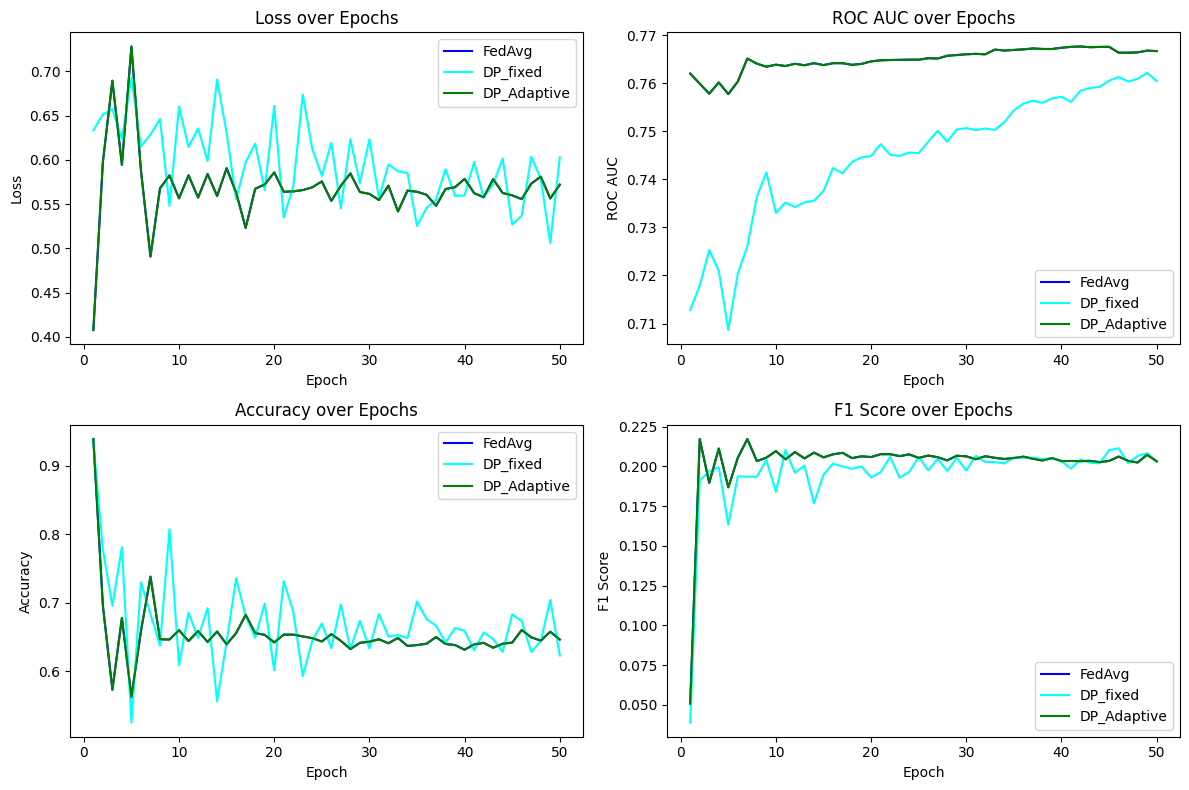

In [11]:
class CustomClient_Paillier(fl.client.NumPyClient):

        
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.losses = []
        self.ROC_AUCs = []
        self.ACCURACYs = []
        self.F1s = []
    
        with open('../public_key.pkl', 'rb') as f:
            self.__public_key = pickle.load(f)

        with open('../private_key.pkl', 'rb') as f:
            self.__private_key = pickle.load(f)


    def get_parameters(self, config):

        print('================== INITIAL PARAMS ==================')
        params = ts.get_model_parameters(model)
        print(params)

        return params

    def fit(self, parameters, config):
        
        print('============================ PARAMS BEFORE  FIT===========================')
  
        # decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        # dec_res = []
        # index = 0
        # for param in parameters:
        #        num_elements = param.size
        #        reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
        #        dec_res.append(reshaped_array)
        #        index += num_elements
        # print(parameters)
        
        ts.set_model_parameters(model, parameters)
                
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train, y_train)
        print(f"Training finished for round {config['server_round']}")
        print('============================= PARAMETERS AFTER FIT ===============================')
        params_1 = ts.get_model_parameters(model)
        print(f'clear: {params_1}')

        encrypted_params = [(self.__public_key.encrypt(value),) for param in params_1 for value in param.flatten()]
        enc_result = []
        index = 0

        for param in params_1:
                num_elements = param.size
                reshaped_array = np.array(encrypted_params[index:index + num_elements]).reshape(param.shape)
                enc_result.append(reshaped_array)
                index += num_elements
            # encrypt parameters here


        print(f'Encrypted: {enc_result}')
        
        return enc_result, len(X_train), {}

    def evaluate(self, parameters, config):
        print('========================== evaluate PARAMS =============================================')
        # i got agg parameters for server, here i have to decrypt them
        print(parameters, parameters[0].size, parameters[1].size)
        decrypted_params = [(self.__private_key.decrypt(value),) for param in parameters for value in param.flatten()]
        dec_res = []
        index = 0
        for param in parameters:
               num_elements = param.size
               reshaped_array = np.array(decrypted_params[index:index + num_elements]).reshape(param.shape)
               dec_res.append(reshaped_array)
               index += num_elements
        print(f' Decrypted for EVAL {dec_res}')


        
        ts.set_model_parameters(model, dec_res)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)
        print(f'accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'f1_score: {f1}')
        self.losses.append(loss)
        self.ROC_AUCs.append(roc_auc)
        self.ACCURACYs.append(accuracy)
        self.F1s.append(f1)
        
        
        parameters[0] = dec_res[0]
        parameters[1]  = dec_res[1]
        print('parameters after eval MUST BE DECRYPTED!')
        print(parameters)
        
        return loss, len(X_test), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}

if __name__ == "__main__":


    client_paillier = CustomClient_Paillier(model, X_train, X_test, y_train, y_test)
    model = LogisticRegression(
        max_iter=1,
    
    )

    ts.set_initial_parameters(model)

    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client_paillier
    )

INFO :      
INFO :      Received: get_parameters message 9c7f62d0-cd2d-44ae-8301-fbd428351a45
INFO :      Sent reply


================== INITIAL PARAMS ==================
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), array([0.])]


INFO :      
INFO :      Received: train message a24f16ae-f71b-454f-9faa-f6f87e182c43


============================ PARAMS BEFORE  FIT===========================
Training finished for round 1
============================= PARAMETERS AFTER FIT ===============================
clear: [array([[-4.39520118e-02, -4.94452864e-02, -6.87200648e-02,
        -8.81334124e-02, -7.64466791e-02,  5.43694916e-02,
        -8.19209966e-02, -3.00138760e-03,  2.10840073e-01,
        -1.80182279e-02, -8.22151147e-02, -5.74585683e-01,
        -6.71071985e-02, -2.65962553e-01,  9.13177174e-02,
        -6.60401510e-02,  4.96981409e-02, -1.14521284e-02,
         4.78860164e-02,  2.81303462e-03, -5.54664466e-04,
        -2.65126517e-01, -8.98509592e-02, -3.21844743e-02,
        -3.04851714e-03, -3.01344921e-02, -2.05836861e-01,
        -1.18783449e-02, -3.35765342e-03, -1.05524195e-01,
        -5.98688082e-01,  0.00000000e+00,  2.61255263e-02]]), array([2.52263739e-16])]


INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000002AFA38F16C0>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000002AFA38F2D70>],
      dtype=object)]


INFO :      
INFO :      Received: evaluate message 922789e4-1537-46a6-9b37-6f7811a963f3


========================== evaluate PARAMS =============================================
[array([[<phe.paillier.EncryptedNumber object at 0x000002AFA38F3790>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000002AFA38F22F0>],
      dtype=object)] 33 1


INFO :      Sent reply
INFO :      
INFO :      Received: train message 4998d015-2a3b-4edd-b4f7-3018a60ecde8


 Decrypted for EVAL [array([[-0.04035642, -0.06838285, -0.04901064, -0.08041477, -0.05967494,
         0.0137327 , -0.05450042, -0.0270502 ,  0.1934429 , -0.01912221,
        -0.06654014, -0.60300138, -0.08105414, -0.28374685,  0.08911177,
        -0.06062822, -0.00356938,  0.00323606,  0.0363628 , -0.00799729,
        -0.00237556, -0.21984822, -0.07152266, -0.0411051 , -0.00924902,
        -0.03192408, -0.15789523, -0.01266152, -0.00180927, -0.0951876 ,
        -0.60414156,  0.        ,  0.0384818 ]]), array([2.60270951e-16])]
accuracy: 0.9393644617380026
ROC_AUC: 0.7620293847566574
f1_score: 0.050761421319796954
parameters after eval MUST BE DECRYPTED!
[array([[-0.04035642, -0.06838285, -0.04901064, -0.08041477, -0.05967494,
         0.0137327 , -0.05450042, -0.0270502 ,  0.1934429 , -0.01912221,
        -0.06654014, -0.60300138, -0.08105414, -0.28374685,  0.08911177,
        -0.06062822, -0.00356938,  0.00323606,  0.0363628 , -0.00799729,
        -0.00237556, -0.21984822, -0.0715226

INFO :      Sent reply


Encrypted: [array([[<phe.paillier.EncryptedNumber object at 0x000002AFA38F3A90>,
      dtype=object), array([<phe.paillier.EncryptedNumber object at 0x000002AFA38F24D0>],
      dtype=object)]


_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "Connection reset"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:127.0.0.1:8080 {created_time:"2024-11-06T18:53:30.8803014+00:00", grpc_status:14, grpc_message:"Connection reset"}"
>

In [ ]:
L_paiil, ROC_AUC_paill, ACCURACY_paill, F1_paill = client_paillier.losses, client_paillier.ROC_AUCs, client_paillier.ACCURACYs, client_paillier.F1s
plot_metrics(L, ROC_AUC, ACCURACY, F1)

In [11]:
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Context

In [7]:
class CustomClient(fl.client.NumPyClient):
    
    def __init__(self):
        
        super().__init__()
        self.lOSS = []
        self.ROC_AUC = []
        self.ACCURACY = []
        self.F1 = []



    def fit(self, parameters, config):
        ts.set_model_parameters(model, parameters)
        print(f'STUDY ::: [LOCAL FIT]')
       
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_train_2, y_train_2)
        
        return ts.get_model_parameters(model), len(X_train_2), {}

    def evaluate(self, parameters, config):
        print(f'STUDY ::: [EVALUATE]')
        ts.set_model_parameters(model, parameters)
        
        y_pred_proba = model.predict_proba(X_test_scale)[:, 1]
        y_pred = model.predict(X_test_scale)
        
        loss = log_loss(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        f1 = f1_score(y_test, y_pred)

        print(f'Accuracy: {accuracy}')
        print(f'ROC_AUC: {roc_auc}')
        print(f'F1_score: {f1}')

        self.lOSS.append(loss)
        self.ROC_AUC.append(roc_auc)
        self.ACCURACY.append(accuracy)
        self.F1.append(f1)
        
        
        return loss, len(X_test_scale), {"accuracy": accuracy, "roc_auc": roc_auc, "f1-score": f1}


if __name__ == "__main__":
    
    N_CLIENTS = 2

    model = LogisticRegression(
        penalty='l2',
        max_iter=10
    )

    ts.set_initial_parameters(model)
    
    
    client = CustomClient()

    
    fl.client.start_client(
        server_address="127.0.0.1:8080",
        client=client
    )

INFO :      
INFO :      Received: get_parameters message 7c478650-82d1-48f5-8582-4221df9f2494
INFO :      Sent reply


INFO :      
INFO :      Received: train message 5d88dc24-eba1-4cf8-ac99-594545e06725
ERROR :     Client raised an exception.
Traceback (most recent call last):
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\app.py", line 379, in _start_client_internal
    reply_message = client_app(message=message, context=context)
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\client_app.py", line 98, in __call__
    return self._call(message, context)
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\client_app.py", line 81, in ffn
    out_message = handle_legacy_message_from_msgtype(
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\message_handler\message_handler.py", line 130, in handle_legacy_message_from_msgtype
    fit_res = maybe_call_fit(
  File "c:\Users\Астемир\.pyenv\pyenv-win\versions\3.10.6\lib\site-packages\flwr\client\client.py",

IndexError: list index out of range